<h1>Extraindo os textos dos PDFs das normas</h1>
<p>Os normativos de IOs (Instruções de Operação) incluem muitas palavras específicas instruindo como fazer manobras em equipamentos, que não estão muito presentes em outros normativos. A intenção é que o sistema consiga diferenciar quais os documentos contém sequências de manobras dos que não possuem.</p>
<p>O primeiro passo tomado foi a importação e normalização dos dados, baixando os documentos do site do ONS, na seção Sobre o ONS -> Procedimentos de Rede -> MPO os documentos do item 3. Instruções de Operação - SM 5.12 (um arquivo compactado de 338 MB com 1222 arquivos PDF) e então separados os procedimentos da região Sul (220 arquivos que começam com IO-xx.S.xxxx_Rev.xx).</p>
<p>Com os PDFs selecionados, agora é possível extrair os textos dos documentos. A biblioteca PdfReader auxiliou no processo, como o código a seguir demonstra:</p>

In [ ]:
#########################################
# Bloco para transformar os PDFs em TXT 
#########################################

#%pip install pypdf

from pypdf import PdfReader
import os

directory_in_str = 'C:/Users/Notebook/Desktop/Mestrado/DataScience2/Dataset/'
directory = os.fsencode(directory_in_str)

print('Lendo os PDFs e transformando em TXT...')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.pdf'): 
        with open(f'{filename[:-4]}.txt', 'w', encoding='utf-8') as f:
            reader = PdfReader(directory_in_str+filename)
            text = ""
            for page in reader.pages:
                text += page.extract_text() + "\n"
            f.write(text)
            #print(f'{filename[:-4]}.txt gerado!')
print('Arquivos .txt gerados!')

<p>Agora os documentos extraídos serão incluídos em um dataframe para ser utilizado pelas ferramentas de tratamento e utilização dos dados. As 'features' iniciais a serem selecionadas são se o documento contém <b>MANOBRAS</b>, qual a <b>REGIAO</b> que ele abrange, o <b>LOCAL</b> que é a sigla oficial da instalação referente ao documento, o <b>TIPO</b> do documento que pode ser OI (operação da instalação) ou OC (operação em contingência), o <b>NOME</b> original do documento e o <b>CONTEUDO</b> do documento que foi transformado em texto para ser analisado.</p>
<p>208 documentos que não são IOs foram incluídos nos dados para fazer a parte de documentos com a marcação de False para <b>MANOBRAS</b>, sendo 122 de CD (Cadastro de Informações Operacionais), 45 de RO (Rotinas Operacionais), 23 de RT (Referências Técnicas) e 18 de RI (Regulamentos Internacionais). A inclusão foi na intenção de manter o dataset equilibrado, sendo 220 selecionados com manobras e estes 208 sem manobras. No bloco seguinte o código também irá fazer a separação desses documentos marcando-os como False para documentos que contém manobras.</p>

In [ ]:
#%pip install pandas transformers 

In [3]:
##########################################
# Bloco para montar o dataset com os TXT 
##########################################

import os
import pandas as pd

manobra = True
documentos = []
for file in os.listdir('.'):
    filename = os.fsdecode(file)
    if filename.endswith('.txt'):
        conteudo = open(filename, "r", encoding="utf-8").read()
        manobra = filename.startswith('IO')
        doc = {"MANOBRAS": manobra, "REGIAO":filename.split('.')[1] ,"LOCAL":filename.split('.')[2].split('_')[0], "TIPO":filename.split('.')[0], "NOME": filename[:-4], "CONTEUDO": conteudo}
        documentos.append(doc)

print(len(documentos))

df = pd.DataFrame(documentos)
df.head()

428


MANOBRAS REGIAO LOCAL   TIPO                 NOME  \
0     False    6MD    01  CD-CT  CD-CT.6MD.01_Rev.35   
1     False    6MD    02  CD-CT  CD-CT.6MD.02_Rev.19   
2     False    6MD    03  CD-CT   CD-CT.6MD.03_Rev.7   
3     False    8XG    01  CD-CT  CD-CT.8XG.01_Rev.12   
4     False    8XG    02  CD-CT   CD-CT.8XG.02_Rev.6   

                                            CONTEUDO  
0   \nManual de Procedimentos da Operação \nMódul...  
1  Manual de Procedimentos da Operação\nMódulo 5 ...  
2  Manual de Procedimentos da Operação\nMódulo 10...  
3   \n \nManual de Procedimentos da Operação \nMó...  
4   \nAlterado pela(s) MOP(s): \nMOP/ONS 463-S/20...

<p>Com os arquivos de texto extraídos, agora será feita a normalização do conteúdo com o auxílio da biblioteca NLTK e seus recursos.</p>

In [5]:
#%pip install nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('punkt_tab')

import nltk
from nltk.tokenize import word_tokenize
import unicodedata

stopwords = nltk.corpus.stopwords.words('portuguese')

def remove_acentos(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

stopwords = [remove_acentos(palavra) for palavra in stopwords]

def normaliza_texto(txt):
    return ' '.join([word for word in word_tokenize(str.lower(remove_acentos(txt))) if word not in stopwords and word.isalpha()])

df['CONTEUDO_NORMALIZADO'] = df.apply(lambda linha: normaliza_texto(str(linha['CONTEUDO'])), axis = 1)

df['CONTEUDO_NORMALIZADO'].head()

0    manual procedimentos operacao modulo submodulo...
1    manual procedimentos operacao modulo submodulo...
2    manual procedimentos operacao modulo submodulo...
3    manual procedimentos operacao modulo submodulo...
4    alterado s mop s manual procedimentos operacao...
Name: CONTEUDO_NORMALIZADO, dtype: object

<p>Gerando novo arquivo de texto com o conteúdo normalizado, para exportar ao Doccano para anotação:</p>

In [ ]:
##################################################################
# Para criação dos arquivos .norm.txt com o conteúdo normalizado 
##################################################################

# Iterando pelas linhas do DataFrame e criando os arquivos
for index, row in df.iterrows():
    # Defina o nome do arquivo e o conteúdo
    nome_arquivo = row['NOME'] + '.norm.txt'  # Adiciona a extensão .txt
    conteudo = row['CONTEUDO_NORMALIZADO']
    
    # Criando e escrevendo no arquivo
    with open(nome_arquivo, 'w', encoding='utf-8') as f:
        f.write(conteudo)
    
    #print(f'Arquivo "{nome_arquivo}" criado com sucesso!')

<p>Com base no conteúdo dos documentos, foram elaboradas listas que servem para anotar os textos dos documentos, eles foram divididos nas categorias:
<ul>
    <li>Primeiramente <b>comando</b> para sinalizar palavras que atribuem ação a ser tomada, que geralmente são os comandos ou ações que os agentes devem cumprir e é o que se procura no documento para sinalizar que ele contém sequências de <b>MANOBRAS</b>;</li> 
    <li>Alguns termos que representam algum <b>agente</b> que pode estar envolvido nas manobras;</li>
    <li>Também alguns termos que indicam se há manobras de <b>recomposicao</b>, que são relevantes para os agentes terem ciência de suas ações caso ocorra alguma contingência;</li>
    <li>E termos que relacionam algum <b>equipamento</b> que pode ser manobrado, pois se no documento existir manobras, elas são realizadas em algum tipo de equipamento.</li>
</ul>
<p>Os termos de cada item podem ser vistos no código a seguir na variável <code>labels_map</code> e foram selecionados de acordo com a experiência do autor na área do assunto abordado nos documentos; por serem documentos normativos há uma certa padronização nos termos em todos os documentos, o que torna a anotação manual de cada documento um trabalho extremamente repetitivo.</p>

In [168]:
labels_map = {
    'comando': ['fechamento', 'abertura', 'religamento manual', 'religamento automatico', 'religamento', 
		   'sentido normal', 'sentido inverso', 'envio tensao', 'recebimento tensao', 'solicitar',
		   'impedimento', 'manobra', 'desenergizacao', 'energizacao', 'ligar', 'desligar', 'energizar', 
		   'desenergizar', 'operacao normal', 'condição normal', 'fechados', 'abertos', 'regulacao tensao',
		   'controle tensao', 'modo manual', 'modo automatico', 'abrir', 'fechar', 'manter aberto', 
		   'manter fechado', 'manter abertos', 'manter fechados', 'receber tensao', 'enviar tensao', 
		   'recebendo tensao', 'enviando tensao', 'intervencao', 'fluxo potencia ativa', 'tensao retorno', 
		   'fecha lo', 'abertura manual', 'abertura automatica', 'anel', 'paralelo', 'aberto', 'fechado', 
		   'desligamento automatico', 'desligamentos automaticos', 'esquema', 'esquema especial', 
		   'recebe tensao', 'envia tensao', 'energizando', 'substituir', 'interligando', 'verificar',
		   'energizado', 'desenergizado', 'sentido unico', 'desligados', 'ligados', 'exceto', 'movimentacao', 
		   'manter desligado', 'manter desligados', 'manter ligado', 'manter ligados', 'possibilitar', 'respeitar', 
		   'interligar', 'manobras', 'elevar', 'reduzir', 'diminuir', 'aumentar', 'interromper', 'cortar', 'remanejar',
           'bloquear', 'desbloquear', 'atuar', 'desatuar', 'ligar anel','sentido inverso', 'controlar',
            ],
    'agente': ['ons',  'cnos', 'cosr s', 'cosr se', 'cosr ne', 'cosr nco', 'copel get'],
    'recomposicao': ['recomposicao', 'recompor', 'desligamento parcial', 'desligamentos parciais', 
				'desligamento total', 'desligamentos totais', 'recomposicao fluente', 'desligamento total ou parcial',
				'restabelecimento', 
            ],
    'equipamento': ['linha transmissao', 'linhas transmissao', 'equipamento', 'equipamentos', 'comutador', 
			   'comutadores', 'ltc', 'ltcs', 'modulo interligacao barras', 'modulo interligador barras', 
			   'rede operacao', 'barramento', 'barra', 'barras', 'transformador', 'transformadores', 'disjuntor', 
               'disjuntores', 'reator', 'reatores', 'seccionadora', 'gerador', 'usina', 'capacitor', 'capacitores', 
               'compensador', 'compensadores', 'geradoras', 'geradores' 'seccionadoras', 'conjunto', 'conjuntos', 
               'unidade geradora', 'unidades geradoras', 'conversores', 'conversoras',
            ]
}

########################################################
# Preparando para pré-anotação do conteúdo normalizado 
########################################################

def annotate_text(text, labels_map):
    annotations = []

    # Para cada label e suas palavras associadas
    for label, palavras in labels_map.items():
        for palavra in palavras:
                start_offset = text.find(palavra)
                while start_offset != -1:  # Encontrar todas as ocorrências da palavra
                    end_offset = start_offset + len(palavra)
                    annotations.append([start_offset, end_offset, label])
                    start_offset = text.find(palavra, start_offset + 1)  # Procurar por mais ocorrências
    return annotations

lista_jsons = []
directory_in_str = os.getcwd()
directory = os.fsencode(directory_in_str)

def annotate_from_norm_files():
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith('.norm.txt'): 
            with open(f'{filename[:-4]}.txt', 'r', encoding='utf-8') as t:
                text = t.read()
                # Obter anotações para o texto
                annotations = annotate_text(text, labels_map)
    
                # Criar estrutura de dados no formato que o Doccano aceita
                result = {
                    'text': text,
                    'labels': annotations
                }
                lista_jsons.append(result)
                # Salvar as anotações no formato JSON para importar no Doccano
                #with open(f'{filename[:-9]}.json', 'w', encoding='utf-8') as f:
                #    json.dump(result, f, ensure_ascii=False)
                #    #print(f'{filename[:-9]}.json gerado com sucesso!')
    print('Anotações geradas com sucesso!')

def annotate_from_norm_dataset():
    for text in df['CONTEUDO_NORMALIZADO']:
        annotations = annotate_text(text, labels_map)
        # Criar estrutura de dados no formato que o Doccano aceita
        result = {
            'text': text,
            'labels': annotations
            }
        lista_jsons.append(result)
    print('Anotações geradas com sucesso!')

#annotate_from_norm_files()
annotate_from_norm_dataset()

# Adicionando os labels no dataframe principal
df['LABELS'] = pd.DataFrame(lista_jsons)['labels']

with open(f'dados_anotacoes.jsonl', 'w', encoding='utf-8') as f:
    for t in lista_jsons:    
        json.dump(t, f, ensure_ascii=False) 
        f.write('\n')

with open(f'dados_anotacoes.json', 'w', encoding='utf-8') as f:
    json.dump(lista_jsons, f, ensure_ascii=False)            

Anotações geradas com sucesso!


In [ ]:
df.head()

In [170]:
####################
# Separar os dados para treinamento e teste do modelo
####################

from sklearn.model_selection import train_test_split
import json

def load_doccano_data(file_path):
    train_data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            doc = json.loads(line)
            text = doc["text"]
            annotations = {"entities": [(start, end, label) for start, end, label in doc["labels"]]}
            train_data.append((text, annotations))
    return train_data
    
doccano_file = "dados_anotacoes.jsonl"
DATA = load_doccano_data(doccano_file)

# Separar em treino e teste
train_data, test_data = train_test_split(DATA, test_size=0.3, random_state=20)

print(f"Total de dados: {len(DATA)}")
print(f"Treinamento: {len(train_data)}, Teste: {len(test_data)}")

# Salvar em arquivos separados
with open("train_data.jsonl", "w", encoding="utf-8") as train_file:
    for text, annotations in train_data:
        json.dump({"text": text, "labels": annotations["entities"]}, train_file, ensure_ascii=False)
        train_file.write("\n")

with open("test_data.jsonl", "w", encoding="utf-8") as test_file:
    for text, annotations in test_data:
        json.dump({"text": text, "labels": annotations["entities"]}, test_file, ensure_ascii=False)
        test_file.write("\n")

Total de dados: 428
Treinamento: 299, Teste: 129


In [178]:
###################
# Ajustar os dados anotados para treinamento, removendo overlap e alinhando as anotações
###################

import spacy
from spacy.training import offsets_to_biluo_tags

def load_doccano_data(file_path):
    train_data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            doc = json.loads(line)
            text = doc["text"]
            annotations = {"entities": [(start, end, label) for start, end, label in doc["labels"]]}
            train_data.append((text, annotations))
    return train_data
    
#################################

# Remover anotações que possam estar sobrepostas
def remove_overlapping_entities(entities):
    sorted_entities = sorted(entities, key=lambda x: x[0])  # Ordenar por posição inicial
    non_overlapping = []
    for i, (start, end, label) in enumerate(sorted_entities):
        if not non_overlapping or start >= non_overlapping[-1][1]:
            non_overlapping.append((start, end, label))  # Adicionar se não houver sobreposição
    return non_overlapping

#################################

def align_entities_to_tokens(nlp, text, entities):
    doc = nlp.make_doc(text)
    aligned_entities = []
    for start, end, label in entities:
        # Ajustar os offsets para os limites dos tokens
        token_start = doc.char_span(start, end, alignment_mode="expand")
        if token_start:
            aligned_entities.append((token_start.start_char, token_start.end_char, label))
        else:
            print(f"Entidade não alinhada: {text[start:end]}")
    return aligned_entities

#################################

# Carregar os dados anotados
doccano_file = "train_data.jsonl"
TRAIN_DATA = load_doccano_data(doccano_file)

nlp = spacy.blank("pt")  # Modelo vazio para português

# Aplicar a correção em todo o conjunto de treinamento, de alinhamento e remoção de overlap
for i, (text, annotations) in enumerate(TRAIN_DATA):
    TRAIN_DATA[i] = (text, {"entities": align_entities_to_tokens(nlp, text, annotations["entities"])})

for i, (text, annotations) in enumerate(TRAIN_DATA):
    annotations["entities"] = remove_overlapping_entities(annotations["entities"])

#################################

# Verificação de alinhamento
x = 1
for text, annotations in TRAIN_DATA:
    doc = nlp.make_doc(text)  # Tokenizar o texto
    try:
        biluo_tags = offsets_to_biluo_tags(doc, annotations["entities"])
        #print(f'passou por aqui {x}')
        x = x+1
    except ValueError as e:
        #print(f"Erro no texto: {text}")
        print(f"Entidades: {annotations['entities']}")
        print(f"Erro: {e}")

###################################

In [ ]:
#################################
# Treinamento do NER do Spacy com as anotações do Doccano, precisa rodar o bloco anterior
#################################

import spacy
from spacy.training.example import Example

ner = nlp.add_pipe("ner", last=True)

# Adicionar os rótulos das entidades
for _, annotations in TRAIN_DATA:
    for ent in annotations["entities"]:
        ner.add_label(ent[2])

# Treinamento
optimizer = nlp.begin_training()
for epoch in range(10):  # Número de épocas
    losses = {}
    for text, annotations in TRAIN_DATA:
        example = Example.from_dict(nlp.make_doc(text), annotations)
        nlp.update([example], drop=0.5, losses=losses)
    print(f"Losses: {losses}")

In [ ]:
output_dir = "./ner_model4"
nlp.to_disk(output_dir)
print(f"Modelo salvo em {output_dir}")

In [308]:
#################
# Anotar Automaticamente os Documentos
#################
import spacy

# Carregar o modelo treinado
nlp = spacy.load("./ner_model3")

# Fazer previsões em novos textos
texts = [
    "Abrir o disjuntor 202 na subestação",
    "Fechar a válvula principal do sistema"
]

for text in texts:
    doc = nlp(text)
    print(f"Texto: {text}")
    print("Entidades previstas:")
    for ent in doc.ents:
        print(f" - {ent.text} ({ent.label_})")

Texto: Abrir o disjuntor 202 na subestação
Entidades previstas:
 - Abrir (comando)
 - disjuntor (equipamento)
Texto: Fechar a válvula principal do sistema
Entidades previstas:
 - Fechar (comando)


In [310]:
#########################################
# Comparar Previsões com Anotações Manuais
#########################################
import spacy

nlp = spacy.load("./ner_model3")

# Criar conjunto de teste a partir do Doccano
TEST_DATA = load_doccano_data("test_data.jsonl")

# Remover anotações que possam estar sobrepostas
def remove_overlapping_entities(entities):
    sorted_entities = sorted(entities, key=lambda x: x[0])  # Ordenar por posição inicial
    non_overlapping = []
    for i, (start, end, label) in enumerate(sorted_entities):
        if not non_overlapping or start >= non_overlapping[-1][1]:
            non_overlapping.append((start, end, label))  # Adicionar se não houver sobreposição
    return non_overlapping

#################################

def align_entities_to_tokens(nlp, text, entities):
    doc = nlp.make_doc(text)
    aligned_entities = []
    for start, end, label in entities:
        # Ajustar os offsets para os limites dos tokens
        token_start = doc.char_span(start, end, alignment_mode="expand")
        if token_start:
            aligned_entities.append((token_start.start_char, token_start.end_char, label))
        else:
            print(f"Entidade não alinhada: {text[start:end]}")
    return aligned_entities

#################################

# Aplicar a correção em todo o conjunto de treinamento, de alinhamento e remoção de overlap
for i, (text, annotations) in enumerate(TEST_DATA):
    TEST_DATA[i] = (text, {"entities": align_entities_to_tokens(nlp, text, annotations["entities"])})

for i, (text, annotations) in enumerate(TEST_DATA):
    annotations["entities"] = remove_overlapping_entities(annotations["entities"])

#################################

# Verificação de alinhamento
x = 1
for text, annotations in TRAIN_DATA:
    doc = nlp.make_doc(text)  # Tokenizar o texto
    try:
        biluo_tags = offsets_to_biluo_tags(doc, annotations["entities"])
        #print(f'passou por aqui {x}')
        x = x+1
    except ValueError as e:
        #print(f"Erro no texto: {text}")
        print(f"Entidades: {annotations['entities']}")
        print(f"Erro: {e}")
        

# Gerar previsões
predictions = []
true_annotations = []

for text, annotations in TEST_DATA:
    doc = nlp(text)
    predicted_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    true_entities = annotations["entities"]

    predictions.append(predicted_entities)
    true_annotations.append(true_entities)

print(f"Predições: {len(predicted_labels)}, Labels: {len(true_labels)}")

#flat_predictions = [entity for pred in predictions for entity in pred]
#flat_true_annotations = [entity for true in true_annotations for entity in true]

#predicted_labels = [label for _, _, label in flat_predictions]
#true_labels = [label for _, _, label in flat_true_annotations]

Predições: 129, Labels: 16254


In [312]:
####################
# Calcular as Métricas
####################
#%pip install seqeval

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

def to_seqeval_format(data, text_data):
    formatted = []
    for entities, text in zip(data, text_data):
        tokens = text.split()  # Supondo separação básica por espaço
        labels = ["O"] * len(tokens)  # Começa com "O" para todos os tokens

        for start, end, label in entities:
            # Encontrar os índices dos tokens correspondentes ao intervalo de caracteres
            token_indices = [i for i, token in enumerate(tokens) if start <= i < end]
            
            if token_indices:
                labels[token_indices[0]] = f"B-{label}"  # Primeiro token como "B-<label>"
                for idx in token_indices[1:]:
                    labels[idx] = f"I-{label}"  # Restante como "I-<label>"

        formatted.append(labels)
    return formatted

true_labels = to_seqeval_format(true_annotations, [text for text, _ in TEST_DATA])
predicted_labels = to_seqeval_format(predictions, [text for text, _ in TEST_DATA])

print("Precisão:", precision_score(true_labels, predicted_labels))
print("Recall:", recall_score(true_labels, predicted_labels))
print("F1:", f1_score(true_labels, predicted_labels))
print("Relatório de Classificação:")
print(classification_report(true_labels, predicted_labels))

Precisão: 0.9963440446411391
Recall: 0.9980724749421742
F1: 0.997207510832932
Relatório de Classificação:
              precision    recall  f1-score   support

      agente       0.99      0.99      0.99       812
     comando       0.99      1.00      0.99       775
 equipamento       1.00      1.00      1.00      2810
recomposicao       1.00      1.00      1.00       791

   micro avg       1.00      1.00      1.00      5188
   macro avg       0.99      1.00      1.00      5188
weighted avg       1.00      1.00      1.00      5188



In [184]:
############################
# Exportar os documentos para visualizar a anotação automática no Doccano
############################

import json

def export_to_doccano(test_data, predictions, output_file):
    
    with open(output_file, "w", encoding="utf-8") as f:
        for (text, _), pred_entities in zip(test_data, predictions):
            doccano_entry = {
                "text": text,
                "label": [pred_entities]
            }
            f.write(json.dumps(doccano_entry, ensure_ascii=False) + "\n")

export_to_doccano(TEST_DATA, predictions, "annotated_data_spacy.jsonl")

In [1]:
import torch
use_cuda = torch.cuda.is_available()
print(use_cuda)


True


In [262]:
########################
# Preparação dos dados para o BERT
########################

from transformers import AutoTokenizer
from datasets import Dataset

##########################################

def align_and_convert_to_bio(data, tokenizer, label2id, max_length=128):
    tokenized_inputs = {"input_ids": [], "attention_mask": [], "labels": []}
    
    for example in data:
        text = example["text"]
        entities = example["entities"]

        # Criar rótulos no formato BIO no nível de caracteres
        char_labels = ["O"] * len(text)
        for start, end, label in entities:
            char_labels[start] = f"B-{label}"
            for i in range(start + 1, end):
                char_labels[i] = f"I-{label}"

        # Tokenizar o texto
        encoding = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_offsets_mapping=True,
        )
        
        offset_mapping = encoding.pop("offset_mapping")
        labels = [-100] * len(offset_mapping)  # Inicializar rótulos alinhados com -100

        # Mapear os rótulos BIO para tokens
        for idx, (start, end) in enumerate(offset_mapping):
            if start == end:  # Ignorar tokens especiais ([CLS], [SEP])
                continue
            char_index = start
            if char_index < len(char_labels):
                labels[idx] = label2id.get(char_labels[char_index], -100)

        tokenized_inputs["input_ids"].append(encoding["input_ids"])
        tokenized_inputs["attention_mask"].append(encoding["attention_mask"])
        tokenized_inputs["labels"].append(labels)

    return tokenized_inputs

#################################

def load_and_filter_doccano_data(doccano_file):
    with open(doccano_file, "r", encoding="utf-8") as f:
        examples = [json.loads(line) for line in f]

    processed_data = []
    for example in examples:
        text = example["text"]
        entities = example["labels"]  # [(start, end, label), ...]

        # Ordenar anotações pelo início e pelo comprimento decrescente
        entities = sorted(entities, key=lambda x: (x[0], -(x[1] - x[0])))

        # Resolver sobreposições
        filtered_entities = []
        last_end = 0
        for start, end, label in entities:
            if start >= last_end:  # Apenas adicionar se não sobrepõe
                filtered_entities.append((start, end, label))
                last_end = end

        processed_data.append({"text": text, "entities": filtered_entities})
    return processed_data

###################################

def create_label2id(data):
    """
    Cria mapas de rótulos (BIO) para IDs.
    """
    labels = set()
    for example in data:
        for _, _, label in example["entities"]:
            labels.add(f"B-{label}")
            labels.add(f"I-{label}")
    labels.add("O")  # Adicionar rótulo "O"

    label2id = {label: idx for idx, label in enumerate(sorted(labels))}
    id2label = {idx: label for label, idx in label2id.items()}
    return label2id, id2label

###################################


# Inicializar o tokenizador do BERT
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

# Criar mapas a partir dos dados carregados
train_data = load_and_filter_doccano_data("train_data.jsonl")
test_data = load_and_filter_doccano_data("test_data.jsonl")
label2id, id2label = create_label2id(train_data)

# Alinhar e converter para BIO
train_processed = align_and_convert_to_bio(train_data, tokenizer, label2id)
test_processed = align_and_convert_to_bio(test_data, tokenizer, label2id)

# Converter para Dataset do Hugging Face
train_dataset = Dataset.from_dict(train_processed)
test_dataset = Dataset.from_dict(test_processed)

In [ ]:
#print("Exemplo de alinhamento:")
#print("Texto original:", train_data[0]["text"])
#print("Entidades:", train_data[0]["entities"])
print("Tokens e Rótulos:")
for token, label_id in zip(
    tokenizer.convert_ids_to_tokens(train_processed["input_ids"][0]),
    train_processed["labels"][0],
):
    print(f"{token} -> {id2label.get(label_id, 'O')}")

In [264]:
# Inspecionar o dataset de treinamento
#for example in train_dataset:
#    print(example)
#    break  # Verificar o primeiro exemplo
print("Labels:", label2id.keys())
#for example in train_dataset:
#    print(example["labels"])
#    break

Labels: dict_keys(['B-agente', 'B-comando', 'B-equipamento', 'B-recomposicao', 'I-agente', 'I-comando', 'I-equipamento', 'I-recomposicao', 'O'])


In [266]:
#############################
# Treino do BERT em português (RODAR O BLOCO ANTERIOR PARA PREPARAR OS DADOS)
#############################

from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import torch

# Carregar o modelo pré-treinado
model = AutoModelForTokenClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)
model.to("cuda")

# Configurações de treinamento
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_dir="./logs",
    logging_steps=10,  # Registrar a cada 10 passos
)

# Criar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Treinar o modelo
trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Notebook\anaconda3\envs\gpu2\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Notebook\AppData\Local\Temp\ipykernel_7680\4149956496.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TrainOutput(global_step=380, training_loss=0.05629072099139816, metrics={'train_runtime': 253.5205, 'train_samples_per_second': 11.794, 'train_steps_per_second': 1.499, 'total_flos': 195331686750720.0, 'train_loss': 0.05629072099139816, 'epoch': 10.0})

In [268]:
# Salvar o modelo, o tokenizador e o treinamento realizado
model_save_path = "./bert-ner-model3"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
trainer.save_model(model_save_path)

In [ ]:
# Recarregar o modelo e tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_save_path)
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

In [270]:
from sklearn.metrics import classification_report
import numpy as np

# Avaliar no conjunto de teste
predictions, labels, _ = trainer.predict(test_dataset)

# Converter logits para rótulos preditos
predicted_labels = predictions.argmax(axis=2)

# Remover os rótulos ignorados (-100)
true_labels = labels.flatten()
predicted_labels = predicted_labels.flatten()

# Filtrar valores -100, que são usados para ignorar tokens que não são entidades
mask = true_labels != -100
true_labels = true_labels[mask]
predicted_labels = predicted_labels[mask]

# Definir os nomes das classes (9 classes no total sem mask)
label_list = list(label2id.keys())
#label_list.append('O')  # 'O' é para tokens fora de entidades

# Gerar o relatório de classificação
print(classification_report(true_labels, predicted_labels, target_names=label_list))

                precision    recall  f1-score   support

      B-agente       1.00      1.00      1.00       147
     B-comando       0.93      0.87      0.90       130
 B-equipamento       0.99      0.99      0.99       206
B-recomposicao       0.88      1.00      0.94        38
      I-agente       1.00      1.00      1.00       177
     I-comando       0.96      0.93      0.94       197
 I-equipamento       0.99      0.99      0.99       275
I-recomposicao       0.95      1.00      0.97       130
             O       1.00      1.00      1.00     14954

      accuracy                           1.00     16254
     macro avg       0.97      0.98      0.97     16254
  weighted avg       1.00      1.00      1.00     16254



In [272]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Recarregar o modelo e tokenizer
#model_save_path = "./bert-ner-model3"
model = AutoModelForTokenClassification.from_pretrained(model_save_path)
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

# Lista de rótulos
label_list = ['O', 'B-agente', 'I-agente', 'B-comando', 'I-comando', 
              'B-equipamento', 'I-equipamento', 'B-recomposicao', 'I-recomposicao']

def annotate_text(text, model, tokenizer, label_list):
    # Tokenizar o texto
    tokenized = tokenizer(text, return_offsets_mapping=True, truncation=True, padding=True, return_tensors="pt")
    offset_mapping = tokenized.pop("offset_mapping")[0]  # Extrair os offsets (batch=0)
    inputs = {k: v.to(model.device) for k, v in tokenized.items()}

    # Obter previsões do modelo
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()

    # Extrair as entidades
    entities = []
    for idx, label in enumerate(predictions):
        if label != 0 and label != tokenizer.pad_token_id:  # Ignorar "O" e [PAD]
            start, end = offset_mapping[idx].tolist()
            # Ignorar tokens sem correspondência no texto original (como subpalavras do tokenizer)
            if start == end:
                continue
            entity_text = text[start:end]
            entities.append((entity_text, start, end, label_list[label]))

    return {"text": text, "labels": entities}

# Exemplo de anotação
new_documents = [
    "Abrir o disjuntor 202 na subestação",
    "Fechar a válvula principal do sistema"
]

for text in new_documents:
    doc = annotate_text(text, model, tokenizer, label_list)
    print(f"Texto: {doc['text']}")
    print("Entidades previstas:")
    for ent in doc["labels"]:
        print(f" - Texto: '{ent[0]}', Início: {ent[1]}, Fim: {ent[2]}, Rótulo: {ent[3]}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Texto: Abrir o disjuntor 202 na subestação
Entidades previstas:
 - Texto: 'Ab', Início: 0, Fim: 2, Rótulo: I-recomposicao
 - Texto: 'ri', Início: 2, Fim: 4, Rótulo: I-recomposicao
 - Texto: 'r', Início: 4, Fim: 5, Rótulo: I-recomposicao
 - Texto: 'o', Início: 6, Fim: 7, Rótulo: I-recomposicao
 - Texto: 'dis', Início: 8, Fim: 11, Rótulo: I-agente
 - Texto: 'junto', Início: 11, Fim: 16, Rótulo: I-equipamento
 - Texto: 'r', Início: 16, Fim: 17, Rótulo: I-equipamento
 - Texto: '202', Início: 18, Fim: 21, Rótulo: I-recomposicao
 - Texto: 'na', Início: 22, Fim: 24, Rótulo: I-recomposicao
 - Texto: 'sub', Início: 25, Fim: 28, Rótulo: I-recomposicao
 - Texto: 'estação', Início: 28, Fim: 35, Rótulo: I-agente
Texto: Fechar a válvula principal do sistema
Entidades previstas:
 - Texto: 'Fe', Início: 0, Fim: 2, Rótulo: I-recomposicao
 - Texto: 'char', Início: 2, Fim: 6, Rótulo: I-recomposicao
 - Texto: 'a', Início: 7, Fim: 8, Rótulo: I-recomposicao
 - Texto: 'válv', Início: 9, Fim: 13, Rótulo: I-re

In [280]:
import numpy as np
from transformers import Trainer
from datasets import Dataset
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score


# Carregar o conjunto de teste já processado (dataset Hugging Face)
# Supondo que test_dataset foi preparado previamente
predictions, labels, _ = trainer.predict(test_dataset)

# Converter logits em predições
predicted_labels = np.argmax(predictions, axis=2)  # (batch_size, seq_len)

# Obter as máscaras de atenção para evitar avaliar tokens de padding
attention_mask = np.array(test_dataset["attention_mask"])

# Converter para Rótulos BIO
def align_predictions(predictions, labels, id2label, attention_mask):
    true_labels = []
    true_predictions = []

    for prediction, label, mask in zip(predictions, labels, attention_mask):
        sentence_predictions = []
        sentence_labels = []
        for pred, lab, mask_val in zip(prediction, label, mask):
            if mask_val == 1:  # Considerar apenas os tokens válidos
                if lab != -100:  # Ignorar rótulos de padding
                    sentence_labels.append(id2label[lab])
                    sentence_predictions.append(id2label[pred])
        true_labels.append(sentence_labels)
        true_predictions.append(sentence_predictions)

    return true_predictions, true_labels

# Converter predições e rótulos
predicted_bio, true_bio = align_predictions(predicted_labels, labels, id2label, attention_mask)

# Calcular métricas
precision = precision_score(true_bio, predicted_bio)
recall = recall_score(true_bio, predicted_bio)
f1 = f1_score(true_bio, predicted_bio)

# Imprimir o relatório de classificação
report = classification_report(true_bio, predicted_bio)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:\n", report)


Precision: 0.9672447013487476
Recall: 0.9598470363288719
F1-Score: 0.9635316698656431

Classification Report:
               precision    recall  f1-score   support

      agente       1.00      1.00      1.00       147
     comando       0.93      0.86      0.89       132
 equipamento       0.99      0.99      0.99       206
recomposicao       0.86      1.00      0.93        38

   micro avg       0.97      0.96      0.96       523
   macro avg       0.95      0.96      0.95       523
weighted avg       0.97      0.96      0.96       523



In [ ]:
#%pip install seaborn

In [1]:
#################
# Visualização dos resultados
#################
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Extrair rótulos das entidades
train_entities = [label for example in train_data for _, _, label in example["entities"]]
test_entities = [label for example in test_data for _, _, label in example["entities"]]

# Contar frequência de cada classe
train_counts = Counter(train_entities)
test_counts = Counter(test_entities)

# Criar gráfico de barras para distribuição de classes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0])
ax[0].set_title("Distribuição de Classes - Treinamento")
ax[0].set_ylabel("Frequência")
ax[0].set_xlabel("Classes")

sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax[1])
ax[1].set_title("Distribuição de Classes - Teste")
ax[1].set_ylabel("Frequência")
ax[1].set_xlabel("Classes")

plt.tight_layout()
plt.show()

NameError: name 'train_data' is not defined

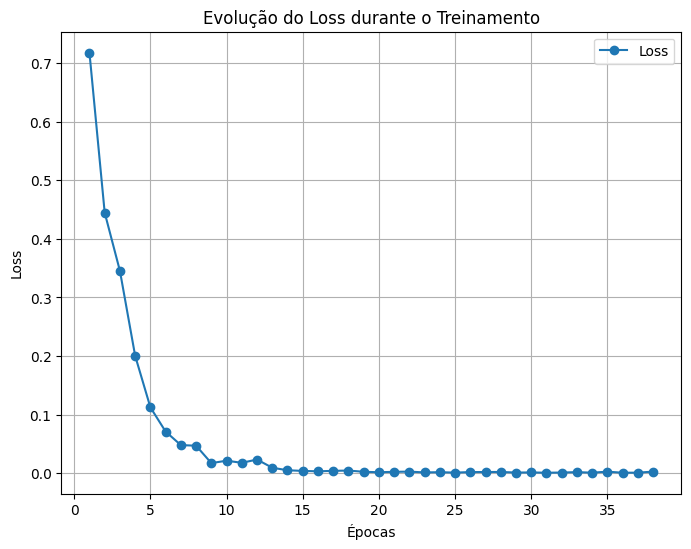

In [290]:
# Extrair histórico de loss
loss_values = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
epochs = range(1, len(loss_values) + 1)

# Plotar gráfico
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, marker='o', label='Loss')
plt.title("Evolução do Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [304]:
import matplotlib.pyplot as plt

# Dados de losses do spaCy
spacy_losses = [116280.06457256238, 11954.934733533566, 5956.669891860886, 
                3550.9617797103956, 2652.15841129514, 2030.1151191420365, 
                1849.7470162362501, 1526.800230221202, 1444.355700329409, 
                1187.1699253929194]
spacy_epochs = list(range(1, len(spacy_losses) + 1))

# Dados de losses do BERT
bert_training_loss = [0.345300, 0.048200, 0.018000, 0.004200, 0.002700, 0.003000, 0.002200, 0.001600, 0.001200, 0.003000]
#bert_validation_loss = [0.157998, 0.046849, 0.030127, 0.029844, 0.028205, 0.030322, 0.028275, 0.028756, 0.028707, 0.029154]
bert_epochs = list(range(1, len(bert_training_loss) + 1))

# Criar o gráfico comparativo
plt.figure(figsize=(10, 6))
plt.plot(spacy_epochs, spacy_losses, marker='o', label='Loss - spaCy (NER)', color='b')
plt.plot(bert_epochs, bert_training_loss, marker='s', label='Training Loss - BERT (NER)', color='g')
#plt.plot(bert_epochs, bert_validation_loss, marker='^', label='Validation Loss - BERT (NER)', color='r')

# Adicionar título e legendas
plt.title('Comparação de Loss entre spaCy e BERT', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(1, max(len(spacy_epochs), len(bert_epochs)) + 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

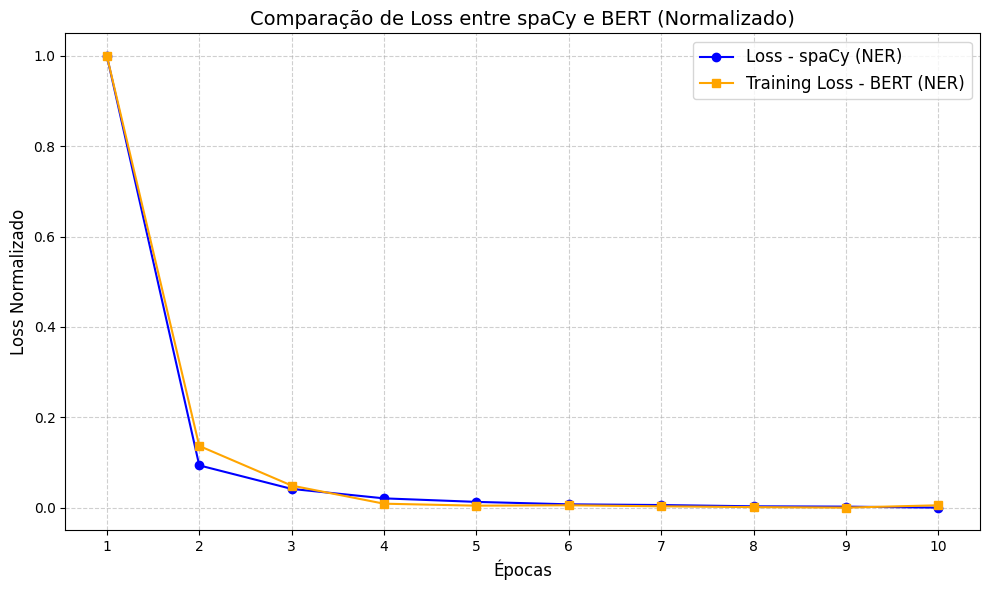

In [316]:
import matplotlib.pyplot as plt
import numpy as np

# Dados de losses do spaCy
spacy_losses = [116280.06457256238, 11954.934733533566, 5956.669891860886, 
                3550.9617797103956, 2652.15841129514, 2030.1151191420365, 
                1849.7470162362501, 1526.800230221202, 1444.355700329409, 
                1187.1699253929194]
spacy_epochs = list(range(1, len(spacy_losses) + 1))

# Dados de losses do BERT
bert_training_loss = [0.345300, 0.048200, 0.018000, 0.004200, 0.002700, 0.003000, 0.002200, 0.001600, 0.001200, 0.003000]
#bert_validation_loss = [0.157998, 0.046849, 0.030127, 0.029844, 0.028205, 0.030322, 0.028275, 0.028756, 0.028707, 0.029154]
bert_epochs = list(range(1, len(bert_training_loss) + 1))

# Normalizar os dados usando Min-Max (escala de 0 a 1)
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return [(x - min_val) / (max_val - min_val) for x in data]

# Normalizando as perdas do spaCy
spacy_losses_normalized = min_max_normalize(spacy_losses)

# Normalizando as perdas do BERT
bert_training_loss_normalized = min_max_normalize(bert_training_loss)
#bert_validation_loss_normalized = min_max_normalize(bert_validation_loss)

# Criar o gráfico comparativo com dados normalizados
plt.figure(figsize=(10, 6))
plt.plot(spacy_epochs, spacy_losses_normalized, marker='o', label='Loss - spaCy (NER)', color='blue')
plt.plot(bert_epochs, bert_training_loss_normalized, marker='s', label='Training Loss - BERT (NER)', color='orange')
#plt.plot(bert_epochs, bert_validation_loss_normalized, marker='^', label='Validation Loss - BERT (NER)', color='r')

# Adicionar título e legendas
plt.title('Comparação de Loss entre spaCy e BERT (Normalizado)', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Loss Normalizado', fontsize=12)
plt.xticks(range(1, max(len(spacy_epochs), len(bert_epochs)) + 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

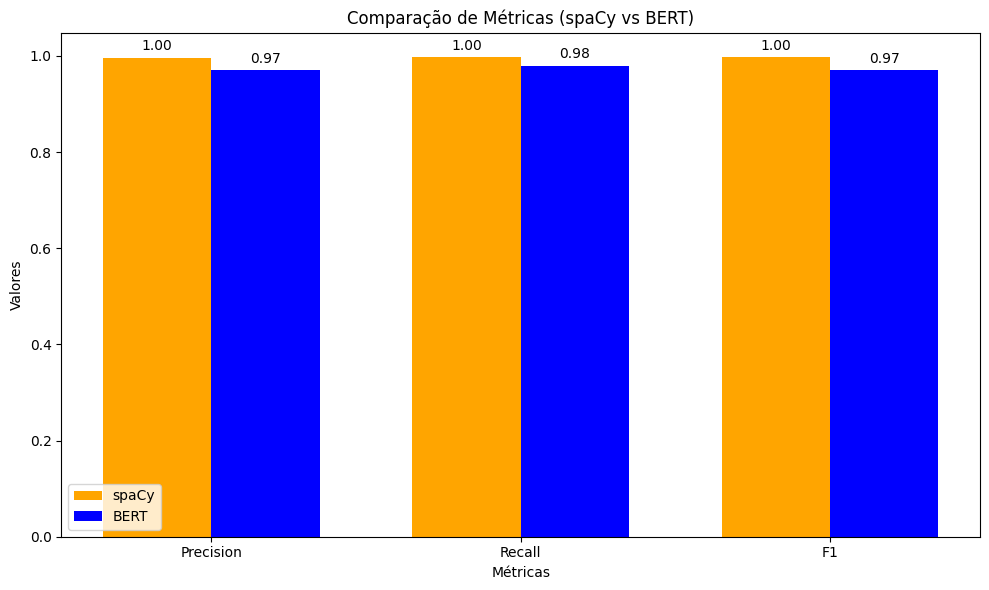

In [320]:
import matplotlib.pyplot as plt
import numpy as np

# Dados do spaCy
spacy_metrics = {
    'Precision': 0.9963440446411391,
    'Recall': 0.9980724749421742,
    'F1': 0.997207510832932
}

# Dados do BERT
bert_metrics = {
    'Precision': 0.97,  # Média Macro do BERT
    'Recall': 0.98,     # Média Macro do BERT
    'F1': 0.97          # Média Macro do BERT
}

# Preparando os dados
metrics = ['Precision', 'Recall', 'F1']
spacy_values = list(spacy_metrics.values())
bert_values = list(bert_metrics.values())

# Definindo a posição das barras
x = np.arange(len(metrics))
width = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(10, 6))

# Criando as barras
rects1 = ax.bar(x - width/2, spacy_values, width, label='spaCy', color='orange')
rects2 = ax.bar(x + width/2, bert_values, width, label='BERT', color='blue')

# Adicionando rótulos e título
ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparação de Métricas (spaCy vs BERT)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Adicionando os valores nas barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Deslocamento para o texto
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

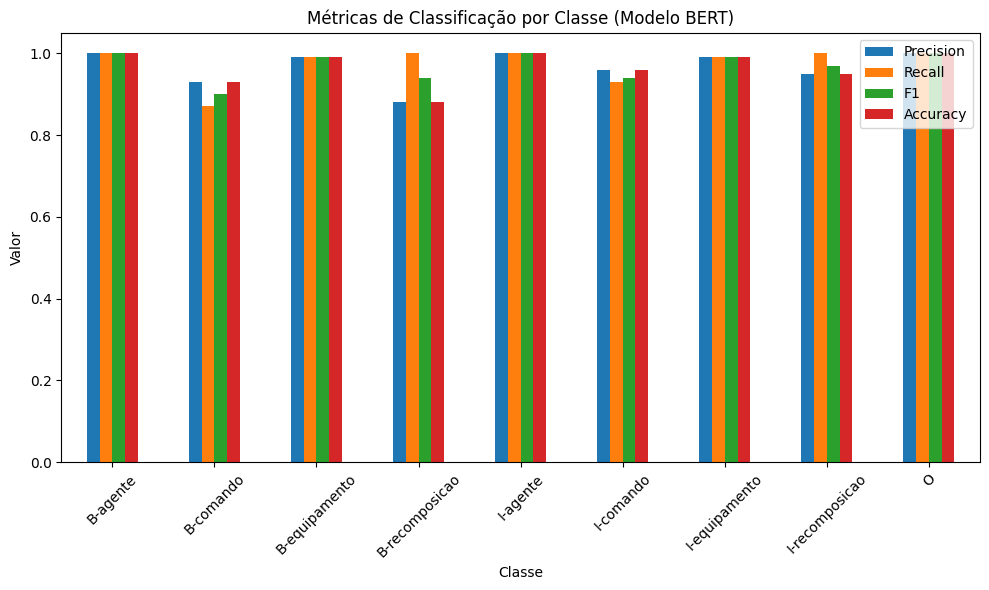

In [328]:
import pandas as pd
import seaborn as sns

# Relatório de Classificação do BERT (Exemplo)
data_bert = {
    'Class': ['B-agente', 'B-comando', 'B-equipamento', 'B-recomposicao', 'I-agente', 'I-comando', 'I-equipamento', 'I-recomposicao', 'O'],
    'Precision': [1.00, 0.93, 0.99, 0.88, 1.00, 0.96, 0.99, 0.95, 1.00],
    'Recall': [1.00, 0.87, 0.99, 1.00, 1.00, 0.93, 0.99, 1.00, 1.00],
    'F1': [1.00, 0.90, 0.99, 0.94, 1.00, 0.94, 0.99, 0.97, 1.00],
    'Accuracy': [1.00, 0.93, 0.99, 0.88, 1.00, 0.96, 0.99, 0.95, 1.00],
}

df_bert = pd.DataFrame(data_bert)

# Gráfico de barras das métricas por classe para o BERT
df_bert.set_index('Class').plot(kind='bar', figsize=(10, 6))
plt.title('Métricas de Classificação por Classe (Modelo BERT)')
plt.ylabel('Valor')
plt.xlabel('Classe')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

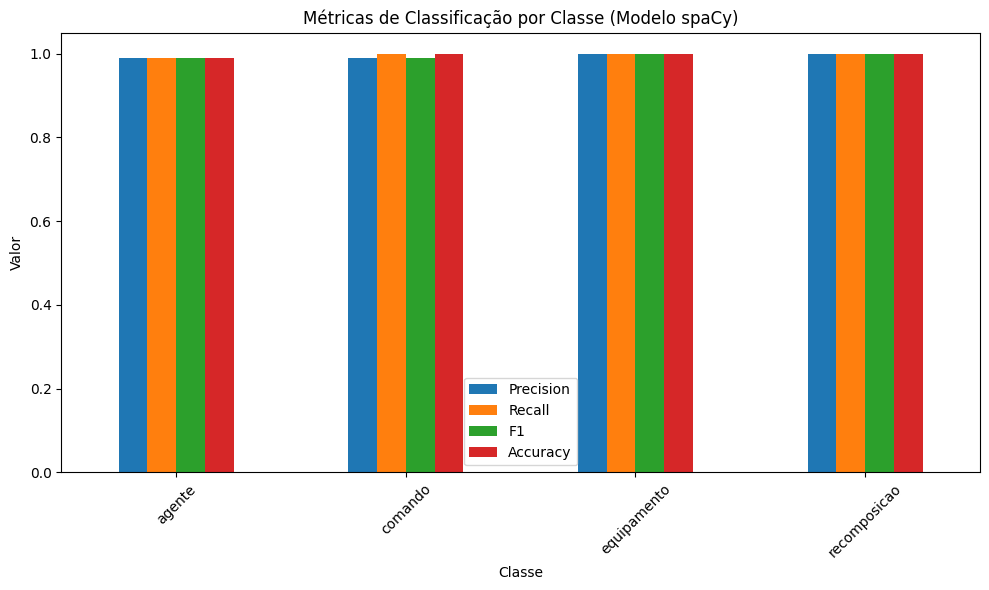

In [334]:
import pandas as pd
import seaborn as sns

# Relatório de Classificação do spaCy (Exemplo)
data_spacy = {
    'Class': ['agente', 'comando', 'equipamento', 'recomposicao'],
    'Precision': [0.99, 0.99, 1.00, 1.00],
    'Recall': [0.99, 1.00, 1.00, 1.00],
    'F1': [0.99, 0.99, 1.00, 1.00],
    'Accuracy': [0.99, 1.00, 1.00, 1.00],
}

df_spacy = pd.DataFrame(data_spacy)

# Gráfico de barras das métricas por classe para o spaCy
df_spacy.set_index('Class').plot(kind='bar', figsize=(10, 6))
plt.title('Métricas de Classificação por Classe (Modelo spaCy)')
plt.ylabel('Valor')
plt.xlabel('Classe')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Acurácia por classe (exemplo para o spaCy)
spacy_accuracy_per_class = {
    'agente': 0.99,
    'comando': 1.00,
    'equipamento': 1.00,
    'recomposicao': 1.00
}

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(spacy_accuracy_per_class.keys(), spacy_accuracy_per_class.values(), color='blue')
plt.title('Acurácia por Classe (Modelo spaCy)')
plt.ylabel('Acurácia')
plt.xlabel('Classe')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#%pip install wordcloud

Documento 258


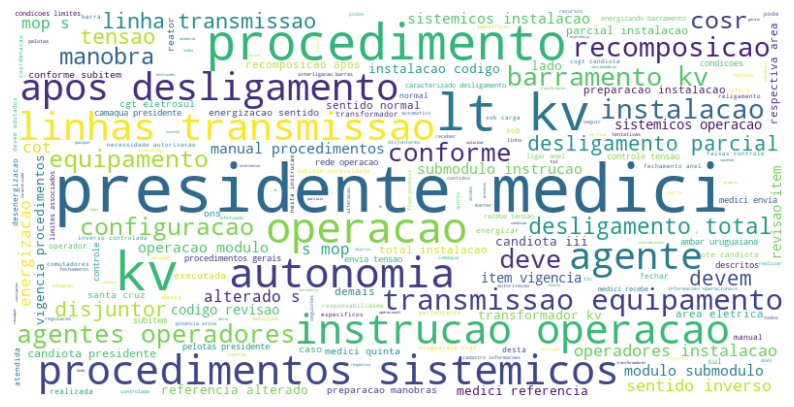

In [423]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

def load_doccano_data(file_path):
    train_data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            doc = json.loads(line)
            text = doc["text"]
            annotations = {"entities": [(start, end, label) for start, end, label in doc["labels"]]}
            train_data.append((text, annotations))
    return train_data

documentos = load_doccano_data("train_data.jsonl")
x = random.randrange(0, 299, 1)

# Concatenar todos os textos em uma única string
text = ''.join(documentos[x][0])

print('Documento', x)
# Gerar a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Exibir a WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove os eixos
plt.show()

In [ ]:
#############
# Teste para visualizar documentos rotulados com spacy
#############

from spacy import displacy

def visualize_entities(text, entities):
    data = {
        "text": text,
        "ents": [{"start": start, "end": end, "label": label} for start, end, label in entities],
        "title": None,
    }
    options = {"colors": {"LABEL": "#f26b6b", "OTHER_LABEL": "#b2d4e6"}}
    displacy.render(data, style="ent", manual=True, options=options)

# Exemplo
example_text = "Abrir o disjuntor 202 na subestação."
example_entities = [(0, 5, "COMANDO"), (11, 20, "EQUIPAMENTO")]
visualize_entities(example_text, example_entities)

<p>Agora, para aprimorar o conteúdo dos dados, serão encontradas entidades nomeadas nos textos originais, com o auxílio da ferramenta SpaCy e adicionados no dataframe original.</p>

In [ ]:
#%pip install spacy
#%pip install blis
#import spacy
#%pip install -U pip setuptools wheel
#%pip install -U spacy[cuda12x]
#%python -m spacy download en_core_web_sm
##python -m spacy download pt_core_news_sm
#spacy.cli.download('en_core_web_sm')
#spacy.cli.download('pt_core_news_sm')

In [ ]:
import spacy

#spacy.prefer_gpu()
#spacy.require_gpu()

nlp = spacy.load('pt_core_news_sm')

def extract_entities(text):
    text.replace('\n',' ')
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append((ent.label_, ent.text))
    return entities

entidades = []
for text in df['CONTEUDO']:
    entidades.append(extract_entities(text))
df['ENTIDADES'] = entidades

In [ ]:
df.head()

In [ ]:
##################################################################
# Para substituição das palavras anotadas pelos termos das anotações 
##################################################################

import re

def replace_terms_with_labels(document, label_to_terms):
    # Criar um mapeamento de cada termo para suas labels
    term_to_label = {}
    for label, terms in label_to_terms.items():
        for term in terms:
            term_to_label[term] = label  # Mapeamento direto do termo para label

    # Função para trocar os termos pelos labels
    def replace_match(match):
        word = match.group(0)  # Pegar a palavra que correspondeu
        #print(f"Termo sendo trocado: {word}")
        #if word not in term_to_label:
        #    print(f"Termo não encontrado para troca: {word}")
        return term_to_label.get(word, word)  # Trocar com a label se corresponder, senão retornar a palavra original
    
    # Usar expressão regular para encontrar todas as palavras e trocar elas pelas labels correspondentes
    result = re.sub(r'\b\w+\b', replace_match, document)
    return result

documents = [replace_terms_with_labels(doc, labels_map) for doc in df['CONTEUDO_NORMALIZADO'].tolist()]
print(len(documents))
#print(documents[0])

df['CONTEUDO_LABELIZADO'] = pd.DataFrame(documents)

In [ ]:
##################################################################
# Para criação dos arquivos .norm.txt com o conteúdo com label trocado 
##################################################################

# Iterando pelas linhas do DataFrame e criando os arquivos
for index, row in df.iterrows():
    # Defina o nome do arquivo e o conteúdo
    nome_arquivo = row['NOME'] + '.labelizado.txt'  # Adiciona a extensão .txt
    conteudo = row['CONTEUDO_LABELIZADO']
    
    # Criando e escrevendo no arquivo
    with open(nome_arquivo, 'w', encoding='utf-8') as f:
        f.write(conteudo)
    
    #print(f'Arquivo "{nome_arquivo}" criado com sucesso!')

<p>Testando uma busca por similaridade com query simples em documentos vetorizados por TFIDF. </p>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

documents = df['CONTEUDO_NORMALIZADO']
documents = df['CONTEUDO_LABELIZADO']

def label_terms_in_document(doc):
    doc_terms = doc.lower().split()  # Tokenização simples
    label_match = {}
    
    for label, terms in labels_map.items():
        # Verifica se algum termo dos labels aparece no documento
        matches = [term for term in terms if term in doc_terms]
        if matches:
            label_match[label] = matches   
    return label_match

# Aplicando o label matching em cada documento
document_labels = [label_terms_in_document(doc) for doc in documents]

# Vetorizando os documentos com TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

# Exemplo de  query
query = "comando"

# Vectorizando a query
query_vec = vectorizer.transform([query])

# Calcular a similaridade por cosseno entre a query e os documentos
cos_sim = cosine_similarity(query_vec, X)

# Rank dos documentos por similaridade
most_relevant_idx = cos_sim.argmax()

# Exibir o documento mais relevante e as labels associadas a ele
print(f"Index do mais relevante: {most_relevant_idx}")
print(f"Nome do Documento: {df['NOME'][most_relevant_idx]}")
print(f"Labels encontradas: {document_labels[most_relevant_idx]}")

In [ ]:
##################################################################
# Fazendo a busca dos TOP 10 documentos mais similares com a query
##################################################################

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents to get their vector representations
X = vectorizer.fit_transform(df['CONTEUDO_NORMALIZADO'])
X = vectorizer.fit_transform(df['CONTEUDO_LABELIZADO'])
X = vectorizer.fit_transform(df['CONTEUDO'])

# Define the query
query = "comando gjr"

# Vectorize the query using the same TF-IDF vectorizer
query_vec = vectorizer.transform([query])

# Compute cosine similarity between the query and each document
cos_sim = cosine_similarity(query_vec, X)

# Convert the cosine similarity result to a DataFrame for easier handling
cos_sim_df = pd.DataFrame(cos_sim.T, columns=['SIMILARIDADE'], index=df.index)

# Sort the documents by similarity in descending order and retrieve the top 10
top_10_similar_documents = cos_sim_df.sort_values(by='SIMILARIDADE', ascending=False).head(10)

# Get the indices of the top 10 documents
top_10_indices = top_10_similar_documents.index

# Retrieve the corresponding documents from the original DataFrame
top_10_documents = df.iloc[top_10_indices]

# Show the top 10 most similar documents along with their similarity scores
top_10_documents['SIMILARIDADE'] = top_10_similar_documents['SIMILARIDADE'].values
print(top_10_documents[['MANOBRAS','REGIAO','LOCAL','TIPO','NOME','SIMILARIDADE']])

In [ ]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

<p>Separando o dataframe para poder fazer treinamento de modelos.</p>

In [ ]:
#%pip install scikit-learn
from sklearn.model_selection import train_test_split

# divide dados em treinamento e teste
df_train, df_test = train_test_split(df, test_size=0.3, random_state=20, shuffle=True)

df_test.head()

<p>Exemplo de classificador com Naive Bayes.</p>

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

data_train = df_train['CONTEUDO_LABELIZADO']
target_train = df_train['MANOBRAS']

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),])
text_clf = text_clf.fit(data_train, target_train)

####### Separando os documentos de teste

data_test = df_test['CONTEUDO_LABELIZADO']
target_test = df_test['MANOBRAS']

predicted = text_clf.predict(data_test)

###### Predição

pd.DataFrame({'Conteudo': df_test['CONTEUDO_LABELIZADO'], 'Predicted': predicted, 'True': target_test})

In [ ]:
## Métricas dos dados treinados ##
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(target_test, predicted, average='macro')

<p>Outro treinamento com  Naive Bayes</p>
<p>O Naive Bayes é um modelo simples, eficiente e bastante eficaz para problemas de classificação de texto, especialmente com dados de texto em grande escala. </p>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Criar o vetor TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)

# Aplicar a vetorização nos textos
X = vectorizer.fit_transform(df['CONTEUDO_NORMALIZADO'])
X = vectorizer.fit_transform(df['CONTEUDO_LABELIZADO'])

# Obter os rótulos dos documentos
y = df['MANOBRAS']

# Dividir os dados em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

# Inicializar o classificador Naive Bayes
nb_classifier = MultinomialNB()

# Treinar o modelo
nb_classifier.fit(X_train, y_train)

# Prever as categorias no conjunto de teste
y_pred = nb_classifier.predict(X_test)

# Avaliar o desempenho do modelo
print("Accuracy do Naive Bayes:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

<p>Treinamento com Logistic Regression</p>
<p>A Logistic Regression um modelo clássico de classificação, que pode ser muito eficaz para tarefas de classificação binária ou multiclasse.</p>

In [ ]:
# Inicializar o classificador Logistic Regression
logreg_classifier = LogisticRegression(max_iter=1000)

# Treinar o modelo
logreg_classifier.fit(X_train, y_train)

# Prever as categorias no conjunto de teste
y_pred_logreg = logreg_classifier.predict(X_test)

# Avaliar o desempenho do modelo
print("Accuracy da Logistic Regression:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

<p>Random Forest</p>
<p>
O Random Forest é um modelo baseado em um conjunto de Árvores de Decisão. Ele melhora a precisão e reduz o overfitting ao treinar várias árvores em subconjuntos aleatórios dos dados e fazer uma média das previsões.
</p>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Inicializar o classificador Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=20)

# Treinar o modelo
rf_classifier.fit(X_train, y_train)

# Fazer previsões
y_pred_rf = rf_classifier.predict(X_test)

# Avaliar o modelo
print("Accuracy do Random Forest:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

<p>Fazendo os Embeddings com <code>FastText</code> da biblioteca <code>gensim</code>.</p>

In [ ]:
#%pip install gensim

In [ ]:
###### GENSIM 

import gensim.downloader as api
from gensim.models import FastText
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load a pre-trained FastText model (Portuguese language-specific)
model = api.load("fasttext-wiki-news-subwords-300")

# Example function to compute the document vector (average of word vectors)
def document_vector(doc, model):
    # Tokenize the document
    tokens = word_tokenize(doc, language='portuguese')
    # Filter out tokens that are not in the model
    vectors = [model.key_to_index[word] for word in tokens if word in model.key_to_index]
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Example query
query = "recomposicao gnb"

# Compute vector for the query
query_vector = document_vector(query, model)

# Compute vectors for each document in the DataFrame
df['doc_vector'] = df['CONTEUDO_LABELIZADO'].apply(lambda x: document_vector(x, model))

# Compute similarity between query and each document
df['similarity'] = df['doc_vector'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])

# Sort by similarity
df_sorted = df.sort_values(by='similarity', ascending=False)
print(df_sorted[['CONTEUDO_LABELIZADO', 'similarity']])

<p>Usando o <code>Sentence-BERT(SBERT)</code> da biblioteca <code>sentence_transformers</code> em português para gerar embeddings com semântica.</p>

In [ ]:
#%pip install sentence-transformers

In [ ]:
##### BERTIMBAU, 

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load a Portuguese SBERT model
model = SentenceTransformer('neuralmind/bert-large-portuguese-cased')

# Function to encode a document into a vector
def encode_document(document, model):
    return model.encode([document])[0]  # Encode the document and return the first vector

# Example query
query = "recomposicao gnb"

# Encode query and documents
query_vector = encode_document(query, model)
df['doc_vector'] = df['CONTEUDO_LABELIZADO'].apply(lambda x: encode_document(x, model))

# Compute similarity between query and documents
df['similarity'] = df['doc_vector'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])

# Sort documents by similarity
df_sorted = df.sort_values(by='similarity', ascending=False)
print(df_sorted[['CONTEUDO_LABELIZADO', 'similarity']])


<p>Interface para descobrir as similaridades dos documentos com a query, usando TF-IDF e Jaccard.</p>

In [ ]:
#%pip install --upgrade streamlit

In [ ]:
#####################
# Código da aplicação que faz a busca por similaridade
####################

#streamlit run teste.py
import os
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import unicodedata
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import streamlit as st
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

rcParams['font.family'] = 'DejaVu Sans'
#rcParams['font.family'] = 'Liberation Sans'  # Outra alternativa para fontes unicode
rcParams['axes.unicode_minus'] = False  # Resolve o problema com o símbolo de "menos" (-)


labels_map = {
    'comando': ['fechamento', 'abertura', 'religamento manual', 'religamento automatico', 'religamento', 
		   'sentido normal', 'sentido inverso', 'envio tensao', 'recebimento tensao', 'solicitar',
		   'impedimento', 'manobra', 'desenergizacao', 'energizacao', 'ligar', 'desligar', 'energizar', 
		   'desenergizar', 'operacao normal', 'condição normal', 'fechados', 'abertos', 'regulacao tensao',
		   'controle tensao', 'modo manual', 'modo automatico', 'abrir', 'fechar', 'manter aberto', 
		   'manter fechado', 'manter abertos', 'manter fechados', 'receber tensao', 'enviar tensao', 
		   'recebendo tensao', 'enviando tensao', 'intervencao', 'fluxo potencia ativa', 'tensao retorno', 
		   'fecha lo', 'abertura manual', 'abertura automatica', 'anel', 'paralelo', 'aberto', 'fechado', 
		   'desligamento automatico', 'desligamentos automaticos', 'esquema', 'esquema especial', 
		   'recebe tensao', 'envia tensao', 'energizando', 'substituir', 'interligando', 'verificar',
		   'energizado', 'desenergizado', 'sentido unico', 'desligados', 'ligados', 'exceto', 'movimentacao', 
		   'manter desligado', 'manter desligados', 'manter ligado', 'manter ligados', 'possibilitar', 'respeitar', 
		   'interligar', 'manobras', 'elevar', 'reduzir', 'diminuir', 'aumentar', 'interromper', 'cortar', 'remanejar',
           'bloquear', 'desbloquear', 'atuar', 'desatuar', 'ligar anel','sentido inverso', 'controlar',
            ],
    'agente': ['ons',  'cnos', 'cosr s', 'cosr se', 'cosr ne', 'cosr nco', 'copel get'],
    'recomposicao': ['recomposicao', 'recompor', 'desligamento parcial', 'desligamentos parciais', 
				'desligamento total', 'desligamentos totais', 'recomposicao fluente', 'desligamento total ou parcial',
				'restabelecimento', 
            ],
    'equipamento': ['linha transmissao', 'linhas transmissao', 'equipamento', 'equipamentos', 'comutador', 
			   'comutadores', 'ltc', 'ltcs', 'modulo interligacao barras', 'modulo interligador barras', 
			   'rede operacao', 'barramento', 'barra', 'barras', 'transformador', 'transformadores', 'disjuntor', 
               'disjuntores', 'reator', 'reatores', 'seccionadora', 'gerador', 'usina', 'capacitor', 'capacitores', 
               'compensador', 'compensadores', 'geradoras', 'geradores' 'seccionadoras', 'conjunto', 'conjuntos', 
               'unidade geradora', 'unidades geradoras', 'conversores', 'conversoras',
            ]
}

### Bloco para montar o dataset com os TXT
def montar_dataset():    
    manobra = True
    documentos = []
    for file in os.listdir('.'):
        filename = os.fsdecode(file)
        if filename.endswith('.txt'):
            conteudo = open(filename, "r", encoding="utf-8").read()
            manobra = filename.startswith('IO')
            doc = {"MANOBRAS": manobra, "REGIAO":filename.split('.')[1] ,"LOCAL":filename.split('.')[2].split('_')[0], "TIPO":filename.split('.')[0], "NOME": filename[:-4], "CONTEUDO": conteudo}
            documentos.append(doc)
    
    df = pd.DataFrame(documentos)
    
    ### Bloco para normalizar o conteudo dos documentos
    
    stopwords = nltk.corpus.stopwords.words('portuguese')
    
    def remove_acentos(input_str):
        nfkd_form = unicodedata.normalize('NFKD', input_str)
        return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])
    
    stopwords = [remove_acentos(palavra) for palavra in stopwords]
    
    def normaliza_texto(txt):
        return ' '.join([word for word in word_tokenize(str.lower(remove_acentos(txt))) if word not in stopwords and word.isalpha()])
    
    df['CONTEUDO_NORMALIZADO'] = df.apply(lambda linha: normaliza_texto(str(linha['CONTEUDO'])), axis = 1)
    
    ### Bloco da pré anotação do conteúdo que foi normalizado
    
    def annotate_text(text, labels_map):
        annotations = []
    
        # Para cada label e suas palavras associadas
        for label, palavras in labels_map.items():
            for palavra in palavras:
                    start_offset = text.find(palavra)
                    while start_offset != -1:  # Encontrar todas as ocorrências da palavra
                        end_offset = start_offset + len(palavra)
                        annotations.append([start_offset, end_offset, label])
                        start_offset = text.find(palavra, start_offset + 1)  # Procurar por mais ocorrências
        return annotations
        
    lista_labels = []
    
    for doc in df['CONTEUDO_NORMALIZADO']:
        annotations = annotate_text(doc, labels_map)
        result = {
                    'text': doc,
                    'labels': annotations
                }
        lista_labels.append(result)
    print('Anotações geradas com sucesso!')
    
    df['LABELS'] = pd.DataFrame(lista_labels)['labels']
    
    ### Bloco para substituir as labels pelos termos no texto
    
    def replace_terms_with_labels(document, label_to_terms):
        term_to_label = {}
        for label, terms in label_to_terms.items():
            for term in terms:
                term_to_label[term] = label  # Mapeamento direto do termo para label
    
        # Função para trocar os termos pelos labels
        def replace_match(match):
            word = match.group(0)  # Pegar a palavra que correspondeu
            #print(f"Termo sendo trocado: {word}")
            #if word not in term_to_label:
            #    print(f"Termo não encontrado para troca: {word}")
            return term_to_label.get(word, word)
        
        result = re.sub(r'\b\w+\b', replace_match, document)
        return result
    
    documents = [replace_terms_with_labels(doc, labels_map) for doc in df['CONTEUDO_NORMALIZADO'].tolist()]
    print(f'Quantidade de documentos: {len(documents)}')
    df['CONTEUDO_LABELIZADO'] = pd.DataFrame(documents)
    
    return df

### Bloco que faz a busca dos top 10 documentos similares à query

def encode_sbert(doc):
    return st.session_state.bert_model.encode([doc])[0]

def fit_and_transform_tfidf(corpus, query):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)
    query_vector = vectorizer.transform([query])
    return tfidf_matrix, query_vector, vectorizer

def preprocess_text(text):
    return text.lower().split()

def encode_word2vec(text, model):
    tokens = preprocess_text(text)
    word_vectors = []
    for word in tokens:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

def jaccard_similarity(doc1, doc2):
    set1 = set(doc1.split())
    set2 = set(doc2.split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)
   
def get_top_10_similar_documents(query, selected_df, method, model=None):
    if method == "Word2Vec":
        query_vector = encode_word2vec(query, st.session_state.word2vec_model)
        selected_df['doc_vector'] = selected_df['document'].apply(lambda x: encode_word2vec(x, st.session_state.word2vec_model))
        selected_df['similarity'] = selected_df['doc_vector'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])
    
    elif method == "TF-IDF":
        tfidf_matrix, query_vector, vectorizer = fit_and_transform_tfidf(selected_df['document'], query)
        cosine_similarities = cosine_similarity(query_vector, tfidf_matrix)
        selected_df['similarity'] = cosine_similarities.flatten()
    
    elif method == "Jaccard":
        selected_df['similarity'] = selected_df['document'].apply(lambda x: jaccard_similarity(x, query))
    
    # Retornando os 10 documentos mais similares
    df_sorted = selected_df.sort_values(by='similarity', ascending=False).head(10)
    return df_sorted

def plot_similarity_bars(dataset_name, word2vec_results, tfidf_results, jaccard_results):
    plt.figure(figsize=(10, 6))
    
    plt.barh(word2vec_results['NOME'], word2vec_results['similarity'], color='skyblue', label='Word2Vec', alpha=0.6)
    
    plt.barh(tfidf_results['NOME'], tfidf_results['similarity'], color='orange', label='TF-IDF', alpha=0.6)
    
    plt.barh(jaccard_results['NOME'], jaccard_results['similarity'], color='red', label='Jaccard', alpha=0.6)
    
    plt.xlabel('Similaridade')
    plt.title(f'Similaridade Comparada: {dataset_name}')
    plt.legend()
    plt.tight_layout()
    #plt.show()
    st.pyplot(plt)
    
# Streamlit Interface
st.title("Sistema Buscador de Manobras")

# Initialize session state if it's not already present
if 'data_loaded' not in st.session_state:
    st.session_state.data_loaded = False
    st.session_state.df = None  # Placeholder for selected dataset
    st.session_state.method = None  # Placeholder for selected method
    st.session_state.query = ""  # Placeholder for query
    st.session_state.similarity = None  # Placeholder for similarity results
    st.session_state.sbert_vectors = None  # Placeholder for Sentence-BERT vectors
    st.session_state.tfidf_vectorizer = None  # Placeholder for TF-IDF vectorizer
    st.session_state.tfidf_matrix = None  # Placeholder for TF-IDF matrix
    st.session_state.bert_model = None # Placeholder for Bertimbau model
    st.session_state.word2vec_model = None
    st.session_state.word2vec_model_df1 = None
    st.session_state.word2vec_model_df2 = None
    st.session_state.word2vec_model_df3 = None
    
# Button to load the data
if st.button("Load Data"):
    st.session_state.df = montar_dataset()  # Store the data in session state
    st.session_state.data_loaded = True  # Mark data as loaded
    
    st.session_state.df1 = st.session_state.df.copy()
    st.session_state.df1.columns = ['document' if x=='CONTEUDO' else x for x in st.session_state.df1.columns]
    # Carregar o modelo word2vec do df1
    processed_documents = st.session_state.df1['document'].apply(preprocess_text)
    st.session_state.word2vec_model_df1 = Word2Vec(sentences=processed_documents, vector_size=100, window=5, min_count=1, workers=4)
    
    
    st.session_state.df2 = st.session_state.df.copy()
    st.session_state.df2.columns = ['document' if x=='CONTEUDO_NORMALIZADO' else x for x in st.session_state.df2.columns]
    # Carregar o modelo word2vec do df2
    processed_documents = st.session_state.df2['document'].apply(preprocess_text)
    st.session_state.word2vec_model_df2 = Word2Vec(sentences=processed_documents, vector_size=100, window=5, min_count=1, workers=4)
    
    st.session_state.df3 = st.session_state.df.copy()
    st.session_state.df3.columns = ['document' if x=='CONTEUDO_LABELIZADO' else x for x in st.session_state.df3.columns]
    # Carregar o modelo word2vec do df3
    processed_documents = st.session_state.df3['document'].apply(preprocess_text)
    st.session_state.word2vec_model_df3 = Word2Vec(sentences=processed_documents, vector_size=100, window=5, min_count=1, workers=4)
    
    #st.session_state.bert_model = SentenceTransformer('neuralmind/bert-large-portuguese-cased')
    
    st.write("Dados carregados com sucesso!")

if st.session_state.data_loaded:
    selected_dataset = st.selectbox("Escolha a base de dados:", ["Original", "Normalizado", "Lematizado"])
    
    selected_method = st.selectbox(
        "Escolha um método de busca:",
        #["TF-IDF", "💀 Sentence-BERT", "💀 Word2Vec", "Jaccard Similarity"]
        ["TF-IDF", "Word2Vec", "Jaccard Similarity"]
    )

    query = st.text_input("Pesquisar sobre:", st.session_state.query)
    st.session_state.method = selected_method
    st.session_state.query = query

    if query:
        if selected_dataset == "Original":
            selected_df = st.session_state.df1
            st.session_state.word2vec_model = st.session_state.word2vec_model_df1
        elif selected_dataset == "Normalizado":
            selected_df = st.session_state.df2
            st.session_state.word2vec_model = st.session_state.word2vec_model_df2
        else:
            selected_df = st.session_state.df3
            st.session_state.word2vec_model = st.session_state.word2vec_model_df3
            
        if selected_method == "TF-IDF":
            tfidf_matrix, query_vector, vectorizer = fit_and_transform_tfidf(selected_df['document'], query)
            cosine_similarities = cosine_similarity(query_vector, tfidf_matrix)
            selected_df['similarity'] = cosine_similarities.flatten()

        elif selected_method == "Sentence-BERT":
            if st.session_state.sbert_vectors is None:
                st.session_state.sbert_vectors = selected_df['document'].apply(encode_sbert).tolist()
            query_vector = encode_sbert(query)
            cosine_similarities = cosine_similarity([query_vector], st.session_state.sbert_vectors)
            selected_df['similarity'] = cosine_similarities.flatten()

        elif selected_method == "Word2Vec":
            query_vector = encode_word2vec(query, st.session_state.word2vec_model)
            selected_df['doc_vector'] = selected_df['document'].apply(lambda x: encode_word2vec(x, st.session_state.word2vec_model))
            selected_df['similarity'] = selected_df['doc_vector'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])

        elif selected_method == "Jaccard Similarity":
            selected_df['similarity'] = selected_df['document'].apply(lambda x: jaccard_similarity(x, query))

        df_sorted = selected_df.sort_values(by='similarity', ascending=False)
        
        st.subheader("Documentos mais similares:")
        for idx, row in df_sorted.head(10).iterrows():
            st.write(f"**Manobra**: {row['MANOBRAS']} --- **Nome**: {row['NOME']}  --- **Similaridade**: {row['similarity']:.4f}")
            st.write(f"**Região**: {row['REGIAO']} --- **Local**: {row['LOCAL']} --- **Tipo**: {row['TIPO']}")
            st.write("---")
        print(df_sorted.head(10)[['MANOBRAS','REGIAO','LOCAL','TIPO','NOME','similarity']])
        
        # Obtendo os 10 documentos mais similares para cada dataset e método
        top_10_word2vec_dataset1 = get_top_10_similar_documents(query, st.session_state.df1, 'Word2Vec', model=st.session_state.word2vec_model_df1)
        top_10_word2vec_dataset2 = get_top_10_similar_documents(query, st.session_state.df2, 'Word2Vec', model=st.session_state.word2vec_model_df2)
        top_10_word2vec_dataset3 = get_top_10_similar_documents(query, st.session_state.df3, 'Word2Vec', model=st.session_state.word2vec_model_df3)

        top_10_tfidf_dataset1 = get_top_10_similar_documents(query, st.session_state.df1, 'TF-IDF')
        top_10_tfidf_dataset2 = get_top_10_similar_documents(query, st.session_state.df2, 'TF-IDF')
        top_10_tfidf_dataset3 = get_top_10_similar_documents(query, st.session_state.df3, 'TF-IDF')
        
        top_10_jaccard_dataset1 = get_top_10_similar_documents(query, st.session_state.df1, 'Jaccard')
        top_10_jaccard_dataset2 = get_top_10_similar_documents(query, st.session_state.df2, 'Jaccard')
        top_10_jaccard_dataset3 = get_top_10_similar_documents(query, st.session_state.df3, 'Jaccard')

        # Plotando os gráficos para cada dataset
        st.write(f'Aqui estão os resultados da similaridade dos 10 documentos mais relevantes com a query "{query}" encontrados com cada método de busca (Word2Vec, TF-IDF e Jaccard).')

        st.subheader('Documentos Originais')
        plot_similarity_bars('Originais', top_10_word2vec_dataset1, top_10_tfidf_dataset1, top_10_jaccard_dataset1)

        st.subheader('Documentos Normalizados')
        plot_similarity_bars('Normalizados', top_10_word2vec_dataset2, top_10_tfidf_dataset2, top_10_jaccard_dataset2)

        st.subheader('Documentos Lematizados')
        plot_similarity_bars('Lematizados', top_10_word2vec_dataset3, top_10_tfidf_dataset3, top_10_jaccard_dataset3)

